In [1]:
import os
import pandas as pd
import geopandas as gpd
import descartes
import numpy as np
import re

import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', None)

### Finance Data

In [21]:
CLEAN_PATH = '../data/data_clean/us_school_districts.csv'

df = pd.read_csv(CLEAN_PATH)

In [22]:
finances_2016 = df[(df.YRDATA == 2016)]
finances_2016 = finances_2016.reset_index(drop=True)
finances_2016.head()

,STATE,ENROLL,NAME,YRDATA,TOTALREV,TFEDREV,TSTREV,TLOCREV,LOCRTAX,LOCRPROP,LOCREVPAR,PCTTOTAL,PCTFTOT,PCTSTOT,PCTLTOT,TOTALEXP,TCURSPND,TSALWAGE,TEMPBENE,TCURINST,TCURSSVC,PPCSTOT,PPITOTAL,PPSTOTAL
0,Alabama,9609.0,AUTAUGA COUNTY SCHOOL DISTRICT,2016,80867,7447,53842,19578,6797.0,6775.0,NaN,100.0,9.2,66.6,24.2,76672,74185.0,43030.0,18122.0,43843,23941,7622.0,4563.0,2492.0
1,Alabama,30931.0,BALDWIN COUNTY SCHOOL DISTRICT,2016,338236,23710,145180,169346,49106.0,48902.0,NaN,100.0,7.0,42.9,50.1,299880,281647.0,156502.0,61621.0,164977,97231,8942.0,5332.0,3143.0
2,Alabama,912.0,BARBOUR COUNTY SCHOOL DISTRICT,2016,10116,2342,5434,2340,1209.0,1202.0,NaN,100.0,23.2,53.7,23.1,10070,9778.0,5079.0,2064.0,4907,3896,10621.0,5380.0,4272.0
3,Alabama,2842.0,EUFAULA CITY SCHOOL DISTRICT,2016,26182,3558,15900,6724,2844.0,2836.0,NaN,100.0,13.6,60.7,25.7,29843,25477.0,14015.0,5746.0,15302,7901,8851.0,5384.0,2780.0
4,Alabama,3322.0,BIBB COUNTY SCHOOL DISTRICT,2016,32486,3664,21846,6976,1716.0,1572.0,NaN,100.0,11.3,67.2,21.5,31662,30616.0,17107.0,7057.0,16407,11087,8931.0,4882.0,3337.0


### Map Data

In [23]:
# Used to map state codes to state names for map data
state_map = {
    1: 'Alabama',
    2: 'Alaska',
    4: 'Arizona',
    5: 'Arkansas',
    6: 'California',
    8: 'Colorado',
    9: 'Connecticut',
    10: 'Delaware',
    11: 'District of Columbia',
    12: 'Florida',
    13: 'Georgia',
    15: 'Hawaii',
    16: 'Idaho',
    17: 'Illinois',
    18: 'Indiana',
    19: 'Iowa',
    20: 'Kansas',
    21: 'Kentucky',
    22: 'Louisiana',
    23: 'Maine',
    24: 'Maryland',
    25: 'Massachusetts',
    26: 'Michigan',
    27: 'Minnesota',
    28: 'Mississippi',
    29: 'Missouri',
    30: 'Montana',
    31: 'Nebraska',
    32: 'Nevada',
    33: 'New Hampshire',
    34: 'New Jersey',
    35: 'New Mexico',
    36: 'New York',
    37: 'North Carolina',
    38: 'North Dakota',
    39: 'Ohio',
    40: 'Oklahoma',
    41: 'Oregon',
    42: 'Pennsylvania',
    44: 'Rhode Island',
    45: 'South Carolina',
    46: 'South Dakota',
    47: 'Tennessee',
    48: 'Texas',
    49: 'Utah',
    50: 'Vermont',
    51: 'Virginia',
    53: 'Washington',
    54: 'West Virginia',
    55: 'Wisconsin',
    56: 'Wyoming'
}

In [36]:
# Import and configure map data
map_2016 = gpd.read_file('../data/data_clean/unsd_map/unsd_compiled.shp')

# Rename state column to align with finance data - astype int
map_2016 = map_2016.rename(columns={'STATEFP': 'STATE'})
map_2016.STATE = map_2016.STATE.astype(int)

# Exclude US territories (Codes above 56)
map_2016 = map_2016[map_2016.STATE <= 56]

# Map state codes to names
map_2016.STATE = map_2016.STATE.map(state_map)

In [37]:
map_2016.head()

,STATE,UNSDLEA,GEOID,NAME,LSAD,LOGRADE,HIGRADE,MTFCC,SDTYP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,Alabama,00001,0100001,Fort Rucker School District,00,KG,12,G5420,B,E,233059995,2735224,+31.4097368,-085.7458071,"POLYGON ((-85.86572 31.45470, -85.86543 31.454..."
1,Alabama,00003,0100003,Maxwell AFB School District,00,KG,12,G5420,B,E,8476761,566857,+32.3809438,-086.3637490,"POLYGON ((-86.37655 32.39358, -86.37621 32.393..."
2,Alabama,00005,0100005,Albertville City School District,00,KG,12,G5420,None,E,68731806,258708,+34.2631303,-086.2106600,"MULTIPOLYGON (((-86.25104 34.25266, -86.25060 ..."
3,Alabama,00006,0100006,Marshall County School District,00,PK,12,G5420,None,E,1267142967,103647100,+34.3739971,-086.3442702,"MULTIPOLYGON (((-86.10870 34.19063, -86.10873 ..."
4,Alabama,00007,0100007,Hoover City School District,00,KG,12,G5420,None,E,121693900,2594832,+33.3769487,-086.8055789,"MULTIPOLYGON (((-86.66393 33.40902, -86.66333 ..."


### Data Cleaning - 'NAME'

In [26]:
# Create maps to replace abbreviations and drop words
def create_maps(abbreviation_map, drop_map):
    abbreviation_map = {rf'\b{i}\b': word for i, word in my_map.items()}
    drop_map = {rf'\b{i}\b': word for i, word in drop_map.items()}
    
    return(abbreviation_map, drop_map)

my_map = {'schs': 'school district',
         'sch': 'school',
         'dist': 'district',
         'dst': 'district',
         'isd': 'school district',
         'pub': 'public',
         'ex': 'exempted',
         'vlg': 'village',
         'community': 'county',
         'comm': 'county',
         'com': 'county',
         'co': 'county',
         'inc': 'corporation',
         'ind': 'independent',
         'uni': 'unified',
         'unif': 'unified',
         'uf': 'union free',
         'hts': 'heights',
         'supv': 'supervisory',
         'twp': 'township',
         'cty': 'city',
         'ctl': 'central',
         'elem': 'elementary'}

my_drop_map = {'public': '',
            'school': '',
            'schools': '',
            'district': '',
            'merged': '',
            'cusd': '',
            'usd': '',
            'reg': '',
            'jt': '',
            #'r': '',
            'voc': '' }

In [27]:
# Regex replacement dictionaries to clean district names
abbreviation_map, drop_map = create_maps(my_map, my_drop_map)

In [48]:
def clean_NAME(df):
    df.NAME = df.NAME.str.lower()
    
    # Replace abbreviations and drop non-essential words
    df.NAME = df.NAME.replace(abbreviation_map, regex=True)
    df.NAME = df.NAME.replace(drop_map, regex=True)
    
    # Drop 'r-' and 'r' from district codes [ need rX next]
    df.NAME = df.NAME.str.replace(rf" r-", ' ', regex=True)
    df.NAME = df.NAME.str.replace(rf" r ", ' ', regex=True)
    
    # Drop extra district codes found in '()'
    df.NAME = df.NAME.str.replace("\([^()]*\)", '', regex=True)
    
    # Drop '#' and '.' from districts
    df.NAME = df.NAME.str.replace('#', '', regex=False)
    df.NAME = df.NAME.str.replace('.', '', regex=False)
    
    # Cleanup whitespace
    df.NAME = df.NAME.str.rstrip()
    df.NAME = df.NAME.replace("\s+", ' ', regex=True)
    
    df = df.sort_values(['STATE', 'NAME'])
    return df

In [45]:
clean_f = clean_NAME(finances_2016)
clean_m = clean_NAME(map_2016)

print(clean_f[['STATE', 'NAME']].head(10))
print(clean_m[['STATE', 'NAME']].head(10))

       STATE              NAME
97   Alabama  albertville city
126  Alabama    alexander city
32   Alabama    andalusia city
9    Alabama     anniston city
98   Alabama         arab city
83   Alabama       athens city
49   Alabama      attalla city
82   Alabama       auburn city
0    Alabama    autauga county
1    Alabama    baldwin county
      STATE                 NAME
18  Alabama       alabaster city
2   Alabama     albertville city
9   Alabama  alexander city city
10  Alabama       andalusia city
11  Alabama        anniston city
12  Alabama            arab city
13  Alabama          athens city
14  Alabama         attalla city
20  Alabama          auburn city
21  Alabama       autauga county


### Combining Finance and Map data

In [47]:
# Merge on an exact match of state and name of district, 
# only keep the geomtry data and convert to geodataframe
merged_df = clean_f.merge(clean_m[['STATE', 'NAME', 'geometry']], 
                                how='inner', 
                                on=['STATE', 'NAME'])

finances_map_2016 = gpd.GeoDataFrame(merged_df, geometry=merged_df.geometry)

print("The merged data accounts for {}% of the map data set.".format((len(finances_map_2016) / len(map_2016)) * 100))
print("{} data points.".format(len(finances_map_2016)))
finances_map_2016.head()

The merged data accounts for 54.22826186759709% of the map data set.
5906 data points.


,STATE,ENROLL,NAME,YRDATA,TOTALREV,TFEDREV,TSTREV,TLOCREV,LOCRTAX,LOCRPROP,LOCREVPAR,PCTTOTAL,PCTFTOT,PCTSTOT,PCTLTOT,TOTALEXP,TCURSPND,TSALWAGE,TEMPBENE,TCURINST,TCURSSVC,PPCSTOT,PPITOTAL,PPSTOTAL,geometry
0,Alabama,5214.0,albertville city,2016,49795,7277,28885,13633,5125.0,4726.0,NaN,100.0,14.6,58.0,27.4,46778,43700.0,23204.0,9435.0,24173,15092,8226.0,4636.0,2895.0,"MULTIPOLYGON (((-86.25104 34.25266, -86.25060 ..."
1,Alabama,1745.0,andalusia city,2016,18650,2360,9571,6719,755.0,751.0,NaN,100.0,12.7,51.3,36.0,15978,15580.0,8073.0,3237.0,9218,5193,8868.0,5283.0,2976.0,"POLYGON ((-86.52252 31.31342, -86.52249 31.315..."
2,Alabama,2099.0,anniston city,2016,23776,4344,11810,7622,4722.0,4711.0,NaN,100.0,18.3,49.7,32.1,24320,23883.0,12018.0,4843.0,12649,9344,11277.0,6026.0,4452.0,"MULTIPOLYGON (((-85.84967 33.69738, -85.84952 ..."
3,Alabama,2540.0,arab city,2016,23606,1544,15096,6966,1219.0,1217.0,NaN,100.0,6.5,63.9,29.5,26202,23748.0,13565.0,5237.0,14569,7328,9217.0,5736.0,2885.0,"MULTIPOLYGON (((-86.46230 34.31094, -86.46030 ..."
4,Alabama,3933.0,athens city,2016,40524,2990,19155,18379,2427.0,2422.0,NaN,100.0,7.4,47.3,45.4,40785,38240.0,20365.0,7955.0,21893,13162,9532.0,5566.0,3347.0,"MULTIPOLYGON (((-86.87836 34.76554, -86.87832 ..."


In [55]:
# Used for comparing data sets
town = 'montgomery county'

town_f = clean_f[clean_f.NAME.str.contains(town, regex=False)][['STATE', 'NAME']]
town_m = clean_m[clean_m.NAME.str.contains(town, regex=False)][['STATE', 'NAME']]
town_combined = finances_map_2016[finances_map_2016.NAME.str.contains(town, regex=False)][['STATE', 'NAME']]

print("FINANCES ({})".format(len(town_f)))
print('='*15)
print(town_f)
print('='*75)

print("MAP ({})".format(len(town_m)))
print('='*15)
print(town_m)
print('='*75)

print('COMBINED ({})'.format(len(town_combined)))
print('='*15)
print(town_combined)

FINANCES (12)
                STATE                                    NAME
105           Alabama                       montgomery county
2310          Georgia                       montgomery county
3681          Indiana     north montgomery county corporation
3682          Indiana     south montgomery county corporation
4555         Kentucky                       montgomery county
4940         Maryland                       montgomery county
6348      Mississippi                       montgomery county
6721         Missouri                    montgomery county r2
9233   North Carolina                       montgomery county
11375    Pennsylvania  montgomery county intermediate unit 23
11867       Tennessee                       montgomery county
13410        Virginia                       montgomery county
MAP (11)
                STATE                                  NAME
96            Alabama                     montgomery county
1363          Georgia                     montgomer

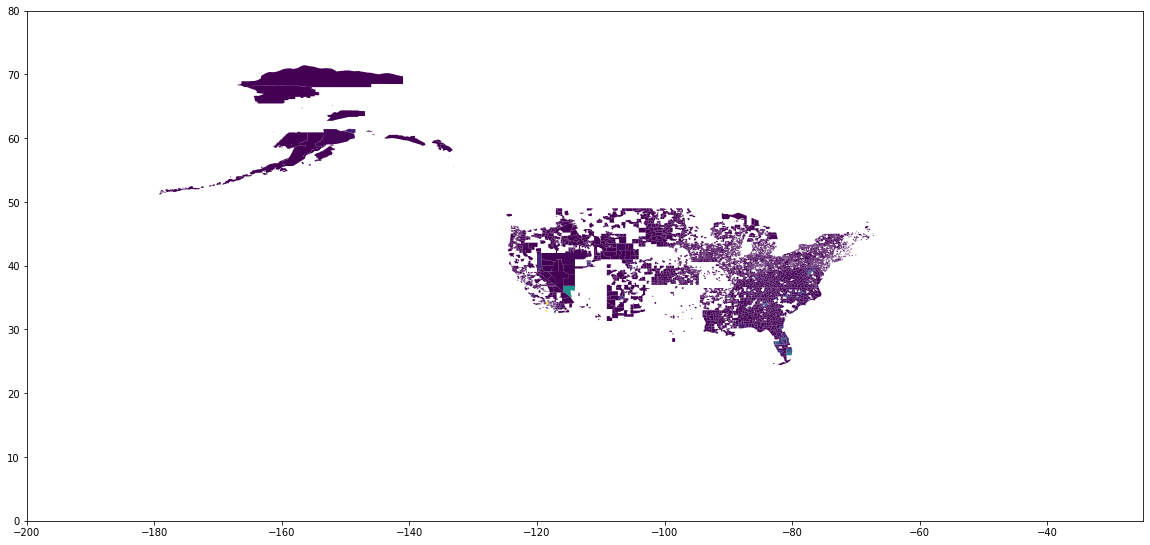

In [179]:
fig = finances_map_2016.plot(column='ENROLL', figsize = (20,20))

plt.xlim([-200,-25])
plt.ylim([0,80])

plt.show()

### Some Stuff?

In [147]:
SCHEMA = ['YRDATA',
'NAME',
'ENROLL',
'TOTALREV',
'TFEDREV',
'TSTREV',
'TLOCREV',
'LOCRTAX',
'LOCRPROP',
#'LOCREVPAR',
'PCTTOTAL',
'PCTFTOT',
'PCTSTOT',
'PCTLTOT',
'TOTALEXP',
'TCURSPND',
'TSALWAGE',
'TEMPBENE',
'TCURINST',
'TCURSSVC',
'PPCSTOT',
'PPITOTAL',
'PPSTOTAL']

def n_largest_or_smallest(df, n, operation):
    """Return a sorted df of the n most/least funded districts

        Parameters:
            df (dataframe): the dataframe to be modified
            n (int): the number of districts to keep
            operation (str)['smallest' or 'largest']: whether to return most/least funded 
        Returns:
            new_df (dataframe): A sorted dataframe of the n most/least funded districts in each state
    """
    
    if operation == 'largest':
        new_df = df.groupby(by='STATE')[SCHEMA].apply(lambda x: x.nlargest(n, columns='TOTALREV')) 
    elif operation == 'smallest':
        new_df = df.groupby(by='STATE')[SCHEMA].apply(lambda x: x.nsmallest(n, columns='TOTALREV'))
    else:
        print("operation must be 'largest' or 'smallest'")
        return
    
    return new_df

In [ ]:
least_funded = n_largest_or_smallest(df_2016, 3, 'smallest')
most_funded = n_largest_or_smallest(df_2016, 3, 'largest')

least_funded.head()
most_funded.head()